In [102]:
%matplotlib inline

In [152]:
import numpy as np
import imp
from klusta.kwik import KwikModel
import matplotlib as mpl
from pylab import *
import ipywidgets as widgets
from IPython.display import display
import seaborn as sns
import os
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
plt.rcParams["animation.html"] = "jshtml"

import sys
sys.path.append('/home/harison/MEGAsync/src/ipy/classes') 
import kwikfile as kf
import micromatrix

class MicroCube:
    
    def __init__(self,Nx=70,Ny=200,kpath=None):
        """!  @brief Creates a MicroCube instance.

        Parameters:

        Nx: Number of matrix columns.
        Ny: Number of matrix rows.
        kpath: Path to the '.kwik' file.

        Example: 
        mc=MicroCube(kpath="/some directory where there is kwikfile")
        Once you downloaded the examples from the phy project in the /tmp directory. You can to instanciate 
        a MicroMatrix object using this:
        mm=MicroCube(kpath="/home/adm/data/2016Apr15/spk/manual/01/g01.kwik")

        @author: Harison P B de Oliveira
        @date: 2018.Jul.10        
        """

        if Nx<70 or Ny<200:
            print("Dimensions of the matrix smaller than the electrode dimensions.")
            return
        else:
            self.Nx=Nx
            self.Ny=Ny
            self.kwik_model=None
            self.kwikfile=None
            self.kpath=None
            self.mm=np.zeros(32)
            if kpath is not None:
                if os.path.exists(kpath) is True:
                    self.kwik_model=KwikModel(kpath)
                    self.kpath=kpath
                    self.kwikfile=kf.KwikFile(kpath)
                    self.geometry=np.matrix([np.flipud (self.kwik_model.channel_positions [:,0])
                                                 ,np.flipud (self.kwik_model.channel_positions [:,1]) ])
                else:
                    print('The file was not found in the directory informed.')
                    return       
                self.V=np.zeros((Ny,Nx,32))
                self.mm=micromatrix.MicroMatrix(kpath=self.kpath)
            else:
                print("Enter a valid kpath.")

    def reset_cube (self):
        """!  @brief Reset each component matrix.

        @author: Harison P B de Oliveira
        @date: 2018.Jul.10
        """ 
        
        self.V=np.zeros((self.Ny,self.Nx,32))
  
    def set_ini_conditions(self,spike_id, first_idx=None):
        """!  @brief Set the potential into cube based on the potentials across the sites, 
        during a given action potential.
  
        Parameters:
        Input: 
          - spike_id: id of the action potential in kwik file;
          - first_idx: first index of the action potential's samples;
        Output:
          - <None>
  
        @author: Harison P B de Oliveira
        @date: 2018.Jul.10
        """
        
        
        w=self.mm.amplitudes_spike_id(group_name="good",spk_id=spike_id) ##TIRAR
        
        for index in range(0,w.shape[1]):
            self.mm.set_ini_conditions(w[0,index,:])
            self.V[:,:,index]=self.mm.V
            self.mm.reset_matrix
        
        
        
  
    def calc_cube(self,maxIter=500,th=0.1):
        """!  @brief Returns an cube with potential distribution of the microspace along the microstants represented within 
        the cube.
  
        Parameters:
        maxIter: Maximum number of iterations.
        th: threshold of changing during the calculation.
  
        @author: Harison P B de Oliveira
        @date: 2018.Jul.10
        """
        
        if self.V is None:
            raise ValueError("Potential matrix is None.")
        if maxIter<0:
            raise ValueError("The number of maximum iterations must be greater than zero.")
            
        for index in range(0,self.V.shape[2]):
            self.mm.V=self.V[:,:,index]
            self.mm.calc_matrix(maxIter=maxIter,th=th)
            self.mm.reset_matrix
            #self.V(:,:,index) = mm.self.V
  
    def save_to_numpy(self,filename,overwrite=False):
        """!  @brief Saves the cube in an '.npy'.

        parameters:

        - filename: name of the file where the MicroMatrix must be saved.

        @author: Harison P B de Oliveira
        @date: 2018.Jul.10
        """
        '''
        Errors:
          - input is a folder
          - File already exists and overwrite is FALSE
          - Does not have permission to write file
        '''
        if(os.path.isdir(filename)):
            raise ValueError("The imput can not be a folder, but a file");
        if(os.path.exist(filename)) and not (overwrite):
            raise ValueError("File alredy exists and can not be overwritten")
        try:
            file = open(filename,'w')
            file.close()
        except IOError as e:
            self.error_msg="Caught the I/O error."
            raise IOError(filename)
        np.save(filename,self.V)
        

    def load_to_numpy(self,filename):
        """!  @brief Loads the cube in an '.npy'.

        parameters:

        filename: name of the file where the MicroCube must be saved.

        @author: Harison P B de Oliveira
        @date: 2018.Jul.10
        """
        '''
        Errors:
          - input is a folder
          - File already exists and overwrite is FALSE
          - Does not have permission to write file
        '''
        if (os.path.isdir(filename)):
            raise ValueError("The input can not be a folder, but a file")
        if (os.path.exists(filename)) is False:        
            raise ValueError("File does not exist.")
        try:
            file = open(filename, 'r')
            file.close()
        except IOError as e:
            raise ValueError("Caught the I/O error")
        self.V=np.load(filename)

    def show_cube(self,xlim=7,ylim=7): ##arrumar para não ter que salvar o arquivo
        """!  @brief Shows graphically the cube with the distribution of potentials.

        parameters:
        xlim: Width of the output image.
        ylim: Height of the output image.

        @author: Harison P B de Oliveira
        @date: 2018.Jul.10
        """
        if self.V is None:
            raise ValueError('The matrix containing the potential distribution in the microspace for a microinstant is None.')
        if xlim<0 or ylim<0:
            raise ValueError('He dimensions of the image can not be less than zero.')
            
        #fig=plt.figure(figsize=(7,20))
        fig,ax = plt.subplots(figsize=(xlim, ylim))
        
        colorinterpolation = 100
        
        cmap = mpl.cm.jet
        norm = mpl.colors.Normalize(vmin=np.min(self.V), vmax=np.max(self.V))
        cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                        norm=norm,
                                        extend='both',
                                        extendfrac='auto',
                                        spacing='uniform',
                                        orientation='vertical') 
        data = np.clip(np.random.randn(0, 0), -1, 1)
        cax = ax.imshow(data, interpolation='None', cmap=mpl.cm.jet)

        def update(i):
            if i<32:
                plt.contourf((self.V[:,:,i]),colorinterpolation, cmap=mpl.cm.jet,
                             vmin=np.min(self.V),vmax=np.max(self.V))
                if i == 0:
                    cbar = fig.colorbar(cax,ticks=[0,0.5,1],orientation='vertical')
                    cbar.ax.set_yticklabels([round(np.min(self.V)),round(np.max(self.V)/2),round(np.max(self.V))])
                    #plt.colorbar()
            else:
                img=self.V[:,:,0]
                img[:,:]=0
                
                plt.contourf(img[:,:],cmap=mpl.cm.gray)
            plt.axes().set_aspect('equal')
       
        return FuncAnimation(fig, update, frames=np.arange(0, 33), interval=50)
            

In [153]:
kpath="/home/harison/UFPE/data/g01.kwik"
#kpath="/home/nvasconcelos/data/atropine/2018May09/01/g01.kwik"
mc=MicroCube(kpath=kpath)

Created class on = /home/harison/UFPE/data/g01.kwik !
Created class on = /home/harison/UFPE/data/g01.kwik !


In [10]:
mc.set_ini_conditions(spike_id=20)

/home/harison/miniconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [11]:
mc.calc_cube()

In [14]:
np.save('cube.npy',mc.V)
#mc.save_to_numpy(filename='cube.npy')

In [154]:
mc.load_to_numpy(filename='cube.npy')

/home/harison/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


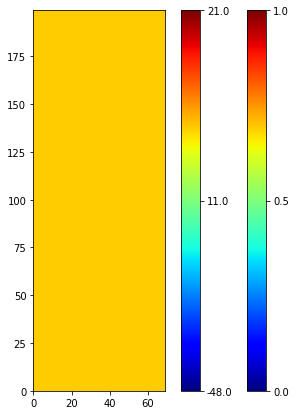

In [155]:
mc.show_cube()

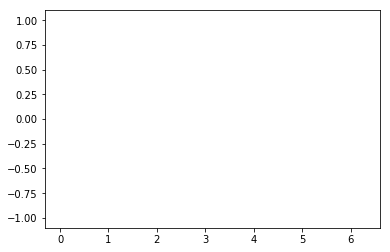

In [96]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["animation.html"] = "html5"
import matplotlib.animation
import numpy as np

t = np.linspace(0,2*np.pi)
x = np.sin(t)

fig, ax = plt.subplots()
l, = ax.plot([0,2*np.pi],[-1,1])

animate = lambda i: l.set_data(t[:i], x[:i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(t))
ani

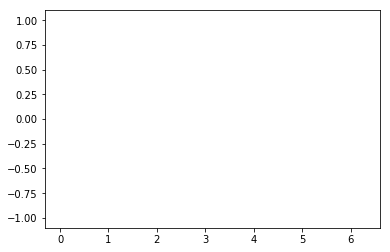

In [100]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["animation.html"] = "html5"
import matplotlib.animation
import numpy as np

t = np.linspace(0,2*np.pi)
x = np.sin(t)

fig, ax = plt.subplots()
l, = ax.plot([0,2*np.pi],[-1,1])

animate = lambda i: l.set_data(t[:i], x[:i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(t))
ani

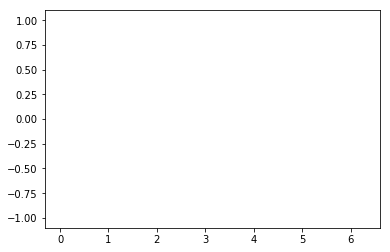

In [101]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["animation.html"] = "jshtml"
import matplotlib.animation
import numpy as np

t = np.linspace(0,2*np.pi)
x = np.sin(t)

fig, ax = plt.subplots()
l, = ax.plot([0,2*np.pi],[-1,1])

animate = lambda i: l.set_data(t[:i], x[:i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(t))
ani

In [35]:
ag=animated_gif(group_name='good',spk_id=6)

In [8]:
mm=micromatrix.MicroMatrix(kpath=kpath)

Created class on = /home/harison/UFPE/data/g01.kwik !


/home/harison/miniconda3/envs/phy/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


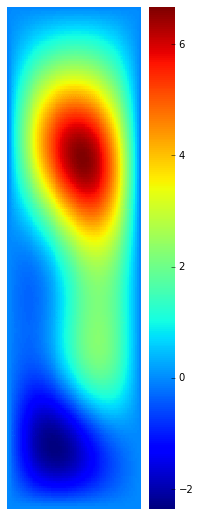

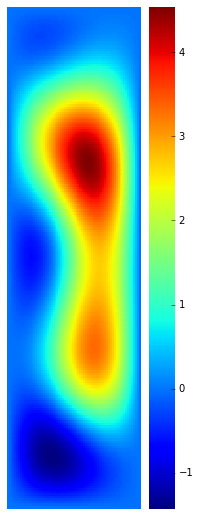

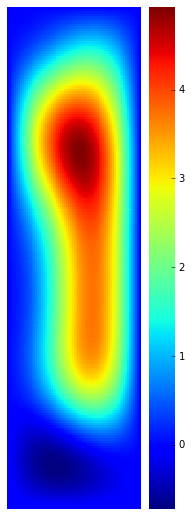

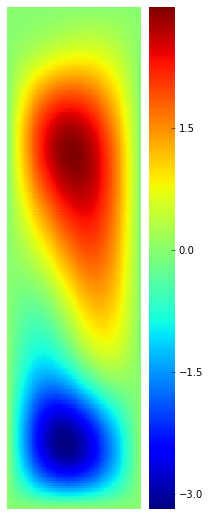

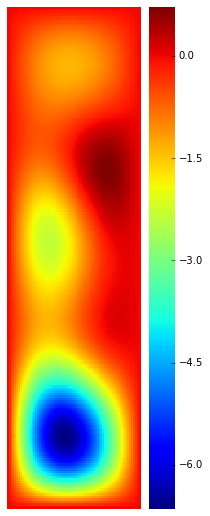

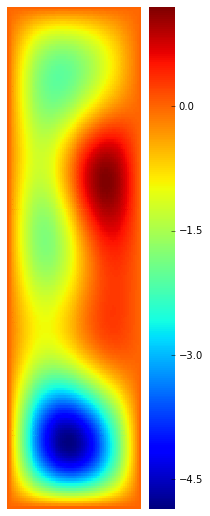

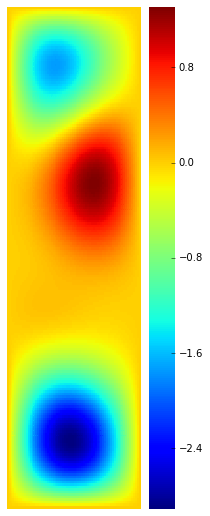

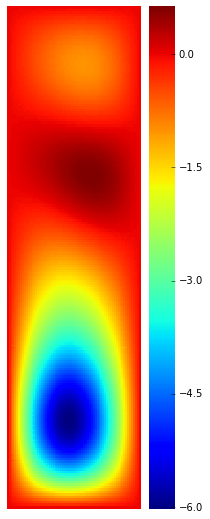

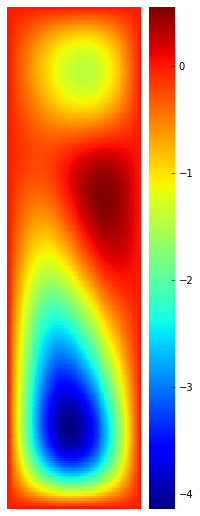

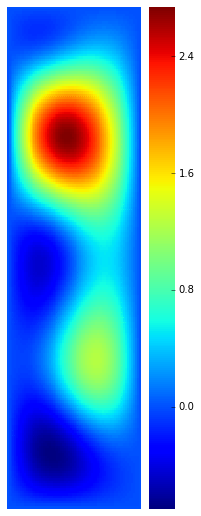

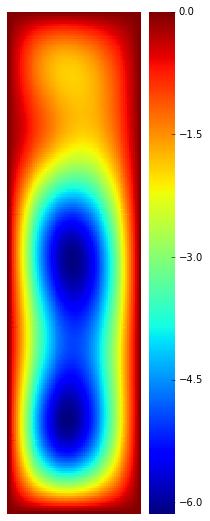

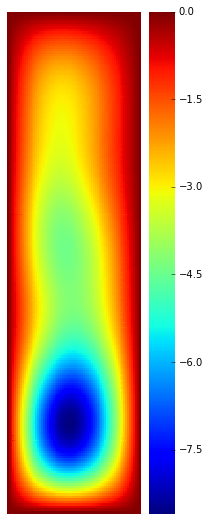

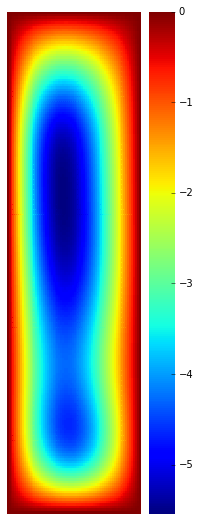

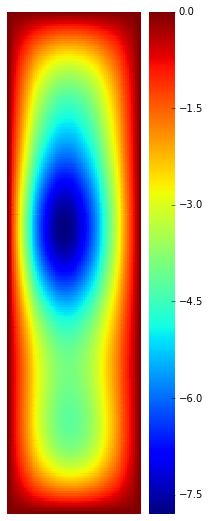

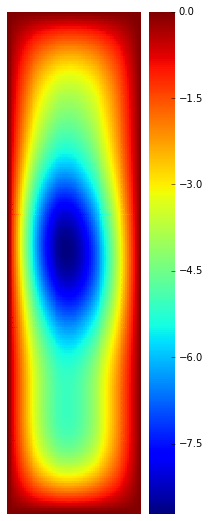

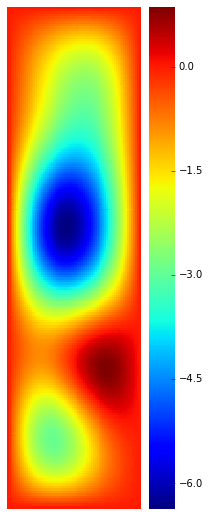

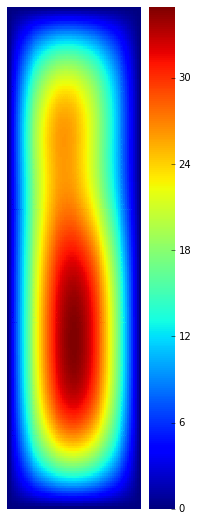

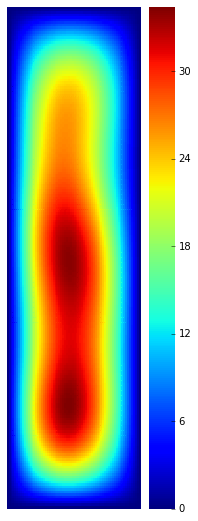

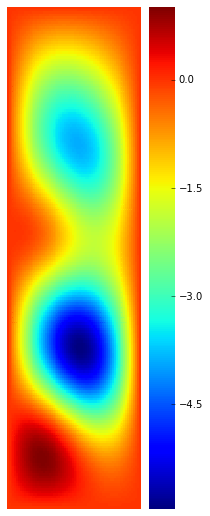

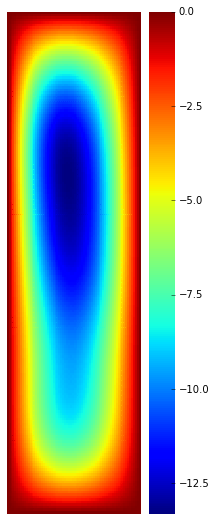

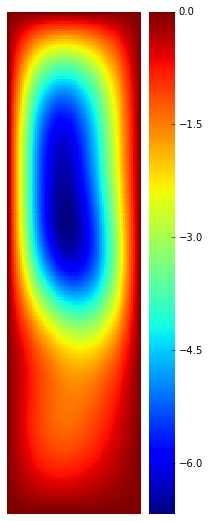

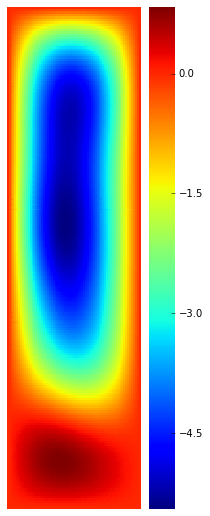

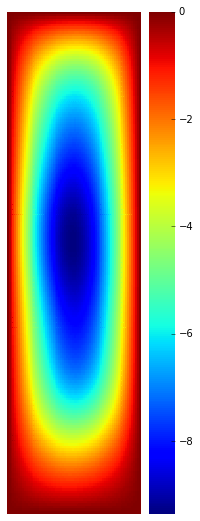

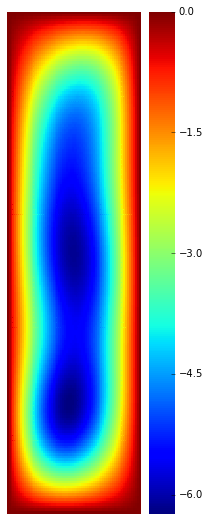

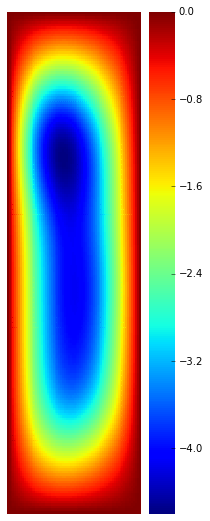

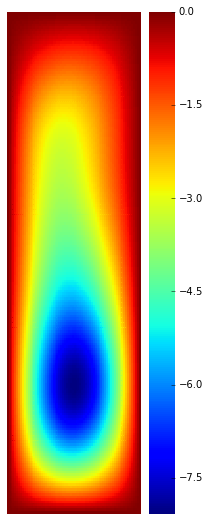

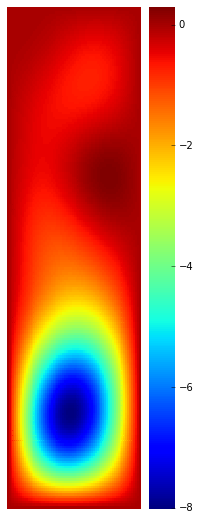

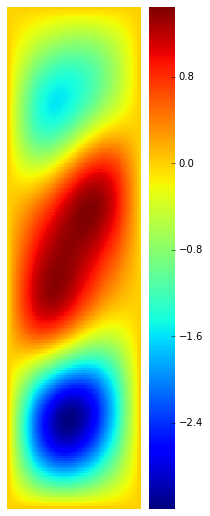

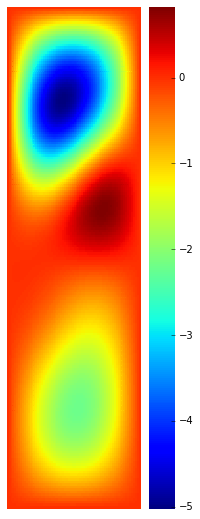

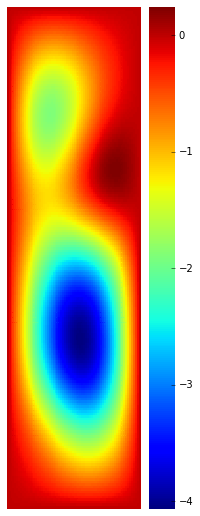

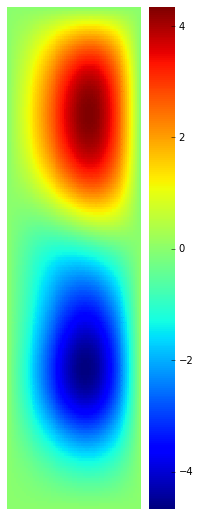

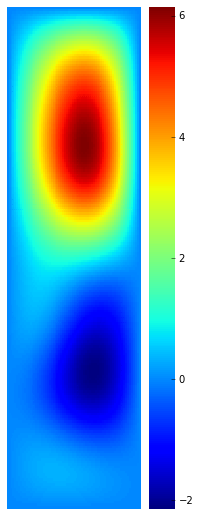

In [9]:
import seaborn as sns
for i in range(0,32):
    plt.figure(figsize=(3,9))
    ax=sns.heatmap(mc.V[:,:,i]*-1,yticklabels=False,xticklabels=False,cmap='jet',cbar_kws={"orientation": "vertical"})


In [21]:
for i in range(0,32):
    mm.V=mc.V[:,:,i]
    mm.show_matrix()
    mm.reset_matrix()

NameError: name 'mm' is not defined

In [13]:
def display_gif(fn):
    from IPython import display
    return display.HTML('<img src="{}">'.format(fn))
fn='good_6.gif'
display_gif(fn)

In [33]:
from IPython import display

def gif_for_cube(cube,group_name=None,spk_id=None):
    fig=plt.figure(figsize=(7,20))
    colorinterpolation = 100

    def update(i):
        if i<32:
            plt.contourf(np.negative(cube[:,:,i]),colorinterpolation, cmap=mpl.cm.jet,
                         vmin=np.min(cube),vmax=np.max(cube))
        else:
            img=cube[:,:,0]
            img[:,:]=0
            plt.contourf(img[:,:],cmap=mpl.cm.gray)

        plt.axes().set_aspect('equal')
        #plt.
        plt.axis('tight')

    anim = FuncAnimation(fig, update, frames=np.arange(0, 33), interval=interval)
    filename='imagens/group name/'+str(self.group_name)+"_"+str(self.spk_id)+".gif"
    anim.save(filename, dpi=dpi, writer='imagemagick')
    plt.close() 
    self.display_gif(filename)

def display_gif(fn):

    return display.HTML('<img src="{}">'.format(fn))
        
        #print("Animated GIF completed!")

In [51]:
from matplotlib.animation import FuncAnimation
import matplotlib as mpl

group_name='good'
spk_id=6
cube=mc.V
interval=1
dpi=60

fig=plt.figure(figsize=(7,20))
colorinterpolation = 100

def update(i):
    if i<32:
        plt.contourf(np.negative(cube[:,:,i]),colorinterpolation, cmap=mpl.cm.jet,
                     vmin=np.min(cube),vmax=np.max(cube))
    else:
        img=cube[:,:,0]
        img[:,:]=0
        plt.contourf(img[:,:],cmap=mpl.cm.gray)

    plt.axes().set_aspect('equal')
    #plt.
    plt.axis('tight')

anim = FuncAnimation(fig, update, frames=np.arange(0, 33), interval=interval)
filename='imagens/group name/'+str(group_name)+"_"+str(spk_id)+".gif"
anim.save(filename, dpi=dpi, writer='imagemagick')
plt.close() 